In [ ]:
#Understanding lstm, using one feature: predicting next value of sine wave

In [1]:
# Importing the necessary libraries
import torch               # PyTorch library for building and training neural networks
import torch.nn as nn      # PyTorch's neural network module for creating layers and models
import numpy as np         # NumPy for numerical computations and data manipulation
import matplotlib.pyplot as plt  # Matplotlib for plotting graphs to visualize results

In [2]:
# Function to create a sine wave dataset
def create_sine_wave_data(seq_length, num_samples):
    # Generate equally spaced values from 0 to num_samples
    x = np.linspace(0, num_samples, num_samples)
    
    # Generate the corresponding sine values for the x values
    y = np.sin(x)
    
    # 'data' will hold sequences of length 'seq_length'
    # 'target' will hold the next value in the sine wave for each sequence
    data = []
    target = []
    
    # Create sequences of sine values and corresponding targets
    for i in range(len(y) - seq_length):
        data.append(y[i:i+seq_length])      # Input sequence
        target.append(y[i+seq_length])      # Next value to predict (target)
    
    return np.array(data), np.array(target) # Return data and target as NumPy arrays


In [3]:
# Define hyperparameters for the LSTM model
seq_length = 10        # Length of input sequence (number of previous time steps used for prediction)
num_samples = 1000     # Total number of samples in the sine wave
hidden_size = 50       # Number of units in the LSTM's hidden layer
num_epochs = 50        # Number of training iterations (epochs)
learning_rate = 0.01   # Learning rate for the optimizer

# Prepare the sine wave dataset
data, target = create_sine_wave_data(seq_length, num_samples)

# Convert the dataset into PyTorch tensors (the data type used by PyTorch models)
# The data is reshaped to add a feature dimension, since LSTM expects input of shape (batch_size, seq_length, input_size)
data = torch.tensor(data, dtype=torch.float32).unsqueeze(2)  # Adding an extra dimension for input_size
target = torch.tensor(target, dtype=torch.float32)           # Target tensor


In [4]:
# Define a basic LSTM model using PyTorch's nn.Module
class BasicLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(BasicLSTM, self).__init__()
        
        # Hidden size determines the number of units in the LSTM's hidden layer
        self.hidden_size = hidden_size
        
        # Define the LSTM layer
        # input_size: number of input features (1 because we are passing one sine value at each time step)
        # hidden_size: number of LSTM units
        # batch_first=True makes sure the batch size comes first in the input shape (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Define a fully connected layer to map the hidden state to the output (next sine wave value)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state (h_0) and cell state (c_0) with zeros
        # h_0 and c_0 have the shape (num_layers, batch_size, hidden_size)
        # Here, num_layers = 1 since we are using a single LSTM layer
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # Initial hidden state
        c_0 = torch.zeros(1, x.size(0), self.hidden_size)  # Initial cell state
        
        # Pass the input through the LSTM layer
        # The output 'out' has the shape (batch_size, seq_length, hidden_size)
        # We discard the second output, which is the new hidden and cell state, not needed in the forward pass
        out, _ = self.lstm(x, (h_0, c_0))
        
        # We only care about the output of the last time step, so we select the last one using 'out[:, -1, :]'
        # This selects the last time step for each sequence in the batch
        out = self.fc(out[:, -1, :])  # Pass the last hidden state through the fully connected layer
        
        return out  # Return the predicted output


In [5]:
# Instantiate the LSTM model
model = BasicLSTM(input_size=1, hidden_size=hidden_size, output_size=1)

# Define the loss function as Mean Squared Error (MSE), which is typical for regression tasks
criterion = nn.MSELoss()

# Define the optimizer as Adam, a popular optimization algorithm, and pass the model's parameters to it
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
# Train the LSTM model
for epoch in range(num_epochs):
    # Set the model to training mode (this is the default mode but it's a good practice to explicitly set it)
    model.train()
    
    # Forward pass: pass the input data through the model to get the predicted output
    outputs = model(data)
    
    # Calculate the loss between the predicted output and the actual target values
    loss = criterion(outputs, target)
    
    # Backward pass: reset the gradients to zero, perform backpropagation, and update the model's parameters
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Perform backpropagation
    optimizer.step()        # Update the model's parameters
    
    # Print the loss value every 10 epochs to monitor the training process
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([990])) that is different to the input size (torch.Size([990, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50], Loss: 0.5000
Epoch [20/50], Loss: 0.5001
Epoch [30/50], Loss: 0.5001
Epoch [40/50], Loss: 0.5000
Epoch [50/50], Loss: 0.5000


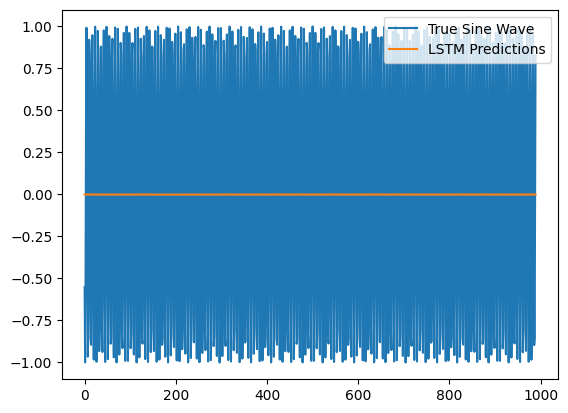

In [7]:
# Switch the model to evaluation mode (disables certain layers like dropout, which we aren't using here)
model.eval()

# Predict the output for the entire dataset using the trained model
# We detach the predictions from the computation graph since we don't need to track gradients in evaluation
predicted = model(data).detach().numpy()

# Plot the true sine wave and the predicted values to visually inspect the model's performance
plt.plot(np.arange(len(target)), target, label='True Sine Wave')   # Plot the true sine wave values
plt.plot(np.arange(len(predicted)), predicted, label='LSTM Predictions')  # Plot the predicted values
plt.legend()  # Add a legend to differentiate between the true values and predictions
plt.show()    # Display the plot
